# Create a simple NN without training with Pytorch + Lightning

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD

import lightning as L
# For Lighting version 2.x
from lightning.pytorch.tuner import Tuner
from torch.utils.data import TensorDataset, DataLoader

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
# Create a class for the pretrained model just as before, the only difference is the parent class
class BasicLightning(L.LightningModule):

    def __init__(self):
        
        super().__init__()

        # Initialise the weights and biases. By turning them into parameters of the neural network, it gives me an option to optimise it
        self.w00 = nn.Parameter(torch.tensor(1.7), requires_grad=False)
        self.b00 = nn.Parameter(torch.tensor(-0.85), requires_grad=False)
        self.w01 = nn.Parameter(torch.tensor(-40.8), requires_grad=False)

        self.w10 = nn.Parameter(torch.tensor(12.6), requires_grad=False)
        self.b10 = nn.Parameter(torch.tensor(0.0), requires_grad=False)
        self.w11 = nn.Parameter(torch.tensor(2.7), requires_grad=False)

        self.final_bias = nn.Parameter(torch.tensor(-16.0), requires_grad=False)

    # Forward method is just the same as before
    def forward(self, input):

        input_to_top_relu = input * self.w00 + self.b00
        top_relu_output = F.relu(input_to_top_relu)
        scaled_top_relu_output = top_relu_output * self.w01

        input_to_bottom_relu = input * self.w10 + self.b10
        bottom_relu_output = F.relu(input_to_bottom_relu)
        scaled_bottom_relu_output = bottom_relu_output * self.w11

        input_to_final_relu =  scaled_top_relu_output + scaled_bottom_relu_output + self.final_bias
        output = F.relu(input_to_final_relu)

        return output

In [9]:
# test if the model works
# Create input values
input_doses = torch.linspace(0, 1, steps=11)
input_doses

tensor([0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
        0.9000, 1.0000])

In [10]:
# Initialise the model
model = BasicLightning()

# Feed the input to the model
output_values = model(input_doses)

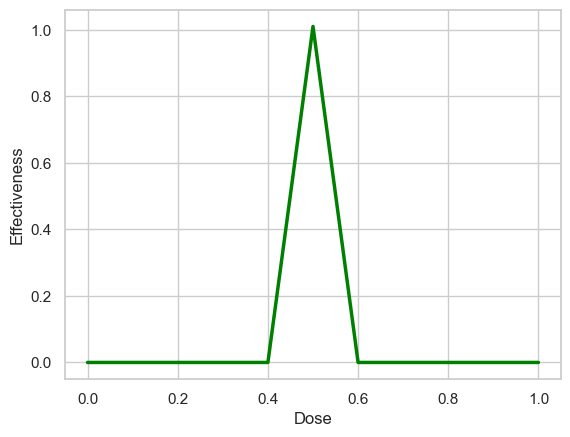

In [11]:
# Plot graph with seaborn and matplotlib
# set up the style of seaborn
sns.set_theme(style="whitegrid")
sns.lineplot(x=input_doses,
             y=output_values,
             color="green",
             linewidth=2.5)

plt.ylabel("Effectiveness")
plt.xlabel("Dose")
plt.show()

# Train one particular parameter - final_bias

In [12]:
# Rename the class to BasicNN_train
class BasicLightningTrain(L.LightningModule):

    def __init__(self):
        
        super().__init__()

        # Initialise the weights and biases. By turning them into parameters of the neural network, it gives me an option to optimise it
        self.w00 = nn.Parameter(torch.tensor(1.7), requires_grad=False)
        self.b00 = nn.Parameter(torch.tensor(-0.85), requires_grad=False)
        self.w01 = nn.Parameter(torch.tensor(-40.8), requires_grad=False)

        self.w10 = nn.Parameter(torch.tensor(12.6), requires_grad=False)
        self.b10 = nn.Parameter(torch.tensor(0.0), requires_grad=False)
        self.w11 = nn.Parameter(torch.tensor(2.7), requires_grad=False)

        # Setting a bias to 0.0 is just a convention and placeholder here
        self.final_bias = nn.Parameter(torch.tensor(0.0), requires_grad=True)

        # Set the learning rate as a variable as Lightning can improve the learning rate for us, right now it is just a placeholder
        self.learning_rate = 0.01

    # Connect the input, activation functions to the output via the weights and biases
    def forward(self, input):

        input_to_top_relu = input * self.w00 + self.b00
        top_relu_output = F.relu(input_to_top_relu)
        scaled_top_relu_output = top_relu_output * self.w01

        input_to_bottom_relu = input * self.w10 + self.b10
        bottom_relu_output = F.relu(input_to_bottom_relu)
        scaled_bottom_relu_output = bottom_relu_output * self.w11

        input_to_final_relu =  scaled_top_relu_output + scaled_bottom_relu_output + self.final_bias
        output = F.relu(input_to_final_relu)

        return output
    
    # With Pytorch + Lightning, we put everything related to the neural network inside the same class (unlike using Pytorch alone)
    def configure_optimizers(self):
        # Set the learning rate to a variable so that we can improve it later
        return SGD(model.parameters(), lr=self.learning_rate)
    
    # Create another method called training step
    def training_step(self, batch, batch_idx):
        input_i, label_i = batch
        # In this case, each batch equals 1 data point
        # print("input_i: " + str(input_i) + "\n")
        # print("label_i: " + str(label_i) + "\n")
        output_i = self.forward(input_i)
        loss = (output_i - label_i)**2 

        return loss


In [13]:
# Create training data
# features
inputs = torch.tensor([0. ,0.5, 1.])

# labels
labels = torch.tensor([0., 1., 0.])

# If we want to simplify the training process with Lightning, we need to turn the training data into dataloaders (for loading the training data into batches, shuffling the batches, and do dirty training for debugging)
# First, create a tensor dataset by combining inputs and labels
dataset = TensorDataset(inputs, labels)
dataloader = DataLoader(dataset)


In [23]:
model = BasicLightningTrain()

# Create Lightning Trainer, which we will use to find a "good" learning rate first for the training later
# Set max_epochs to 34 is because we know 34 is enough for the model to fit the data from before
# The accelerator parameter detects if any accelerator is available; devices returns how many GPU's are available
trainer = L.Trainer(max_epochs=34, accelerator="auto", devices="auto")

# Create a tuner 
tuner = Tuner(trainer)

lr_find_results = tuner.lr_find(model,
                                dataloader,
                                min_lr=0.001,
                                max_lr=0.1,
                                early_stop_threshold=None)


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/edison/Git/pytorch-playground/myenv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/edison/Git/pytorch-playground/myenv/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0016595869074375606
Restoring states from the checkpoint path at /Users/edison/Git/pytorch-playground/.lr_find_b56be7d1-7899-4972-9f5b-baa96cb02011.ckpt
Restored all states from the checkpoint at /Users/edison/Git/pytorch-playground/.lr_find_b56be7d1-7899-4972-9f5b-baa96cb02011.ckpt


In [15]:
new_lr = lr_find_results.suggestion()
print(f"new_lr suggests {new_lr:.5f} for the new learning rate.")

new_lr suggests 0.00166 for the new learning rate.


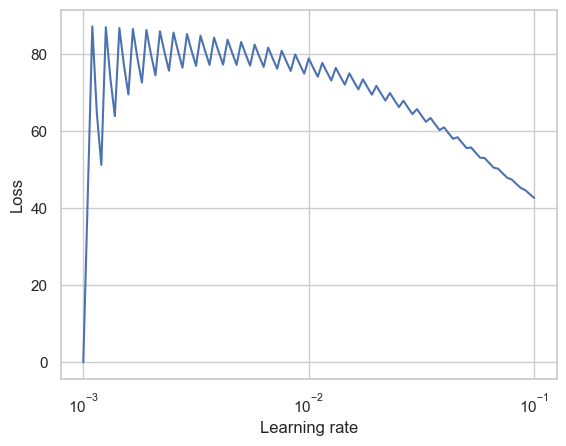

In [16]:
# Optionally, you can also visualize the learning rate finder results
fig = lr_find_results.plot()
plt.show()

In [17]:
# Use the new learning rate
model.learning_rate = new_lr

# Train the model
# It will automatically configure the optimizer by calling the configure_optimizers method and repeat the training_step method until the max_epoch is reached
trainer.fit(model, train_dataloaders=dataloader)


  | Name         | Type | Params | Mode
---------------------------------------------
  | other params | n/a  | 7      | n/a 
---------------------------------------------
1         Trainable params
6         Non-trainable params
7         Total params
0.000     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=34` reached.


In [18]:
print(model.final_bias.data)

tensor(-1.7112)


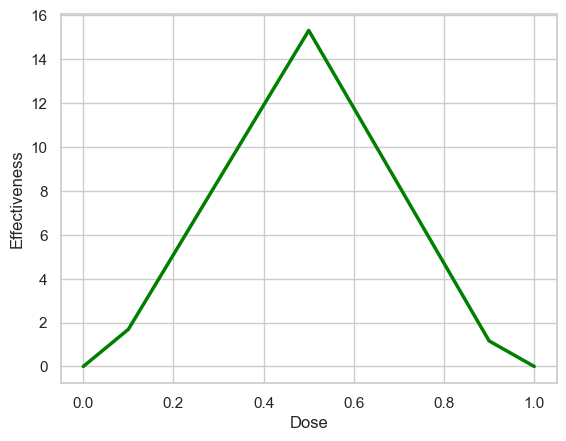

In [19]:
# We already know that it isn't the optimal final bias, but let's just pretend we don't and plot the graph again to see the result

# Feed the input to the model
output_values = model(input_doses)

# Plot graph with seaborn and matplotlib
# set up the style of seaborn
sns.set_theme(style="whitegrid")
sns.lineplot(x=input_doses,
             y=output_values.detach(),
             color="green",
             linewidth=2.5)

plt.ylabel("Effectiveness")
plt.xlabel("Dose")
plt.show()


It suggests further training step is needed as expected.

In [ ]:
# Will come back when we learn how to resume training from where we left off